<a href="https://colab.research.google.com/github/iamalexzis/rvol/blob/main/besov_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from fbm import fgn
import random
T = 5
random.seed(20)
N = 60*60*8*252*T
H = 0.1
fgn_sample = fgn(n=N, hurst=H, length=T, method='daviesharte')

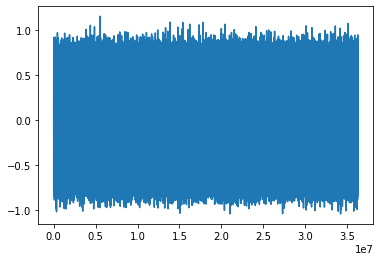

In [3]:
import matplotlib.pyplot as plt
plt.plot(fgn_sample)

In [4]:
import numpy as np
def sim_vol(T,nu,alpha,H,fgn):
    n = len(fgn)
    dt = T/n
    fou = [-3.2]
    for i in range(n-1):
        fou.append(fou[i]+nu*fgn[i+1]*(dt**H)-alpha*(3.2+fou[i])*dt)
    return np.sqrt(np.exp(fou))

In [5]:
nu = 0.3
alpha = 0
vol = sim_vol(T,nu,alpha,H,fgn_sample)

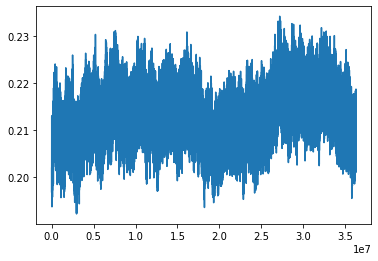

In [6]:
plt.plot(vol)

In [7]:
def sim_price(S0,T,vol):
    n = len(vol)
    dt = T/n
    prices = [S0]
    for i in range(n-1):
        prices.append(prices[i]*np.exp(vol[i+1]*np.random.randn(1)[0]*np.sqrt(dt)-0.5*vol[i+1]**2*dt))
    return prices

In [8]:
S0 = 100
ticks = sim_price(S0,T,vol)

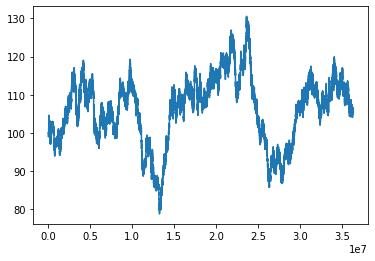

In [9]:
plt.plot(ticks)

In [10]:
import pandas as pds
def rvol(ticks,seconds):
    ticks = pds.DataFrame(ticks,columns=['ticks'])
    log_prices = (abs((np.log(ticks)-np.log(ticks.shift(seconds))).dropna())**2)
    log_prices = log_prices.to_numpy()
    rv_np = []
    for i in range(round(len(log_prices)/28800)-1):
        rv_np.append(sum(log_prices[28800*i:28800*(i+1)]))
    return np.sqrt(rv_np)

In [11]:
def besov_rfsv(rv):
    rv = pds.DataFrame(rv,columns=['rfsv'])
    deltas = np.arange(1,101)
    m2deltas = []
    for delta in deltas:
        m2deltas.append(np.mean(((np.log(rv)-np.log(rv).shift(delta)).dropna())**2))
    y = np.polyfit(np.log(deltas),np.log(m2deltas),deg=1)
    h = y[0]/2
    nu = np.sqrt(np.exp(y[1]))
    return h, nu

In [14]:
rv_1sek = rvol(ticks,1)
h_1sek, nu_1sek = besov_rfsv(rv_1sek)
print('h_1sek = '+str(h_1sek)+', nu_1sek = '+str(nu_1sek))

h_1sek = [0.15362082], nu_1sek = [0.01186571]


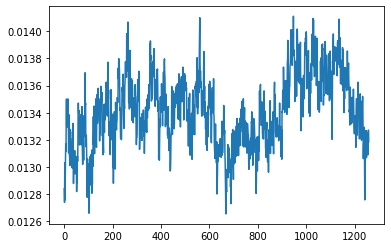

In [15]:
plt.plot(rv_1sek)

In [17]:
rv_5min = rvol(ticks,60*5)
h_5min, nu_5min = besov_rfsv(rv_5min)
print('h_5min = '+str(h_5min)+', nu_5min = '+str(nu_5min))

h_5min = [0.00729206], nu_5min = [0.08691685]


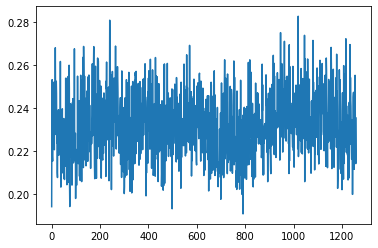

In [18]:
plt.plot(rv_5min)